In [1]:
from sklearn.datasets import make_circles


# Make 1000 samples 
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03, # a little bit of noise to the dots
                    random_state=42) # keep random state so we get the same values

In [2]:
import pandas as pd
circle = pd.DataFrame(
    {"X1": X[:, 0], "X2": X[:, 1], "label": y}
)
circle.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


In [5]:
import matplotlib.pyplot as plt
plt.style.use("dark_background")

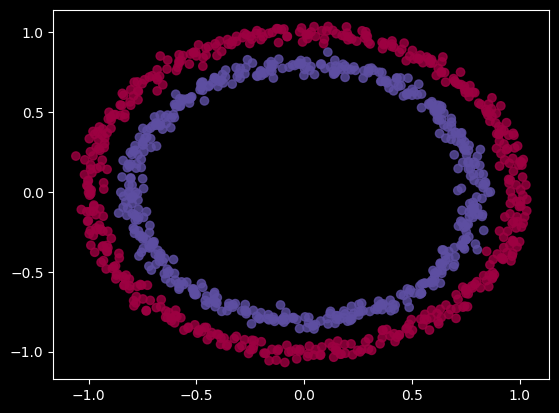

In [7]:
plt.scatter(
    x=X[:, 0],
    y=X[:, 1],
    c=y,
    cmap=plt.cm.Spectral,
    alpha=0.8
)

In [10]:
len(X), len(y)

(1000, 1000)

In [11]:
X.shape, y.shape

((1000, 2), (1000,))

In [13]:
X_sample = X[0]
y_sample = y[0]
X_sample.shape, y_sample.shape

((2,), ())

In [14]:
import torch
torch.__version__

'2.0.0.dev20230220+cu117'

In [15]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
len(X_train), len(X_test)

(800, 200)

In [18]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [37]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)

        # self.two_linear = nn.Sequential(
        #     nn.Linear(in_features=2, out_features=5),
        #     nn.Linear(in_features=5, out_features=1)
        # )

    def forward(self, x):
        return self.layer_2(self.layer_1(x))
        # return self.two_linear(self.layer_1(x))

model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [29]:
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [25]:
model_0.state_dict()

OrderedDict([('two_linear.0.weight',
              tensor([[ 0.3418, -0.4553],
                      [ 0.6009,  0.4793],
                      [-0.5588,  0.6011],
                      [-0.2127, -0.1880],
                      [ 0.5566,  0.4931]], device='cuda:0')),
             ('two_linear.0.bias',
              tensor([ 0.4280, -0.4508,  0.6339,  0.3428, -0.3039], device='cuda:0')),
             ('two_linear.1.weight',
              tensor([[ 0.4446, -0.2533, -0.3926,  0.2925,  0.4243]], device='cuda:0')),
             ('two_linear.1.bias', tensor([0.4464], device='cuda:0'))])

In [41]:
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape of predictions: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape of test samples: {X_test.shape}")
print(f"\nFirst 10 predictions:\n{torch.round(untrained_preds[:10])}")
print(f"\nFirst 10 labels:\n{y_test[:10]}")

Length of predictions: 200, Shape of predictions: torch.Size([200, 1])
Length of test samples: 200, Shape of test samples: torch.Size([200, 2])

First 10 predictions:
tensor([[-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.]], device='cuda:0')

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [42]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [43]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc